# One-step Time Series Prediction task for Sunspot Dataset

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from utils import preprocess
from utils.model_functions import train_model, kfold_cv
from utils.models import simple_LSTM, ACRNN

# Setting Matplotlib default parameters
plt.rcParams.update( {'font.size':14} )

# 1. Setup
## 1.1. Loading the dataset
The preprocessed sunspot dataset for one-step prediction are loaded from the hdf5 file

In [2]:
dataset   = 'sunspot'
file_path = 'data/' + dataset + '_1-step.hdf5'
x, y, true_mean, true_std = preprocess.load_hdf5( file_path )

## 1.2. Helper functions for k-fold cross validation

The evaluation of a model is performed via k-fold cross validation with the help of a helper function found in `utils/model_functions.py`

In [3]:
help( kfold_cv )

Help on function kfold_cv in module utils.model_functions:

kfold_cv(k, x, y, true_mean, true_std, model_func, model_args, compile_kwargs, train_kwargs)
    Performs k-fold cross validation by training the given model on k-folds of the dataset with (k-1)
    folds used for training and 1 fold used for testing. The training step is written as another helper
    function 'train_model' below. The metrics on the test set are reported for the k different models.
    
    Arguments:
    ----------
    k                     -   int
                              number of folds to divide the dataset into.
    x                     -   nD numpy array
                              size: n x window_size
                              input TS with row-wise samples
    y                     -   nD numpy array
                              size: n x prediction_horizon
                              target TS with row-wise samples 
    true_mean             -   float
                              mean

## 1.3. Helper functions for training

The entire training step is written as a helper function found in `utils/model_functions.py`

In [4]:
help( train_model )

Help on function train_model in module utils.model_functions:

train_model(model, x_train, y_train, fold=None, epochs=100, batch_size=32, stopping_patience=50, dataset=None)
    Trains the model based on the given configuration using the training and validation sets.
    Early Stopping is used to monitor improvement of validation loss with specified stopping patience.
    A checkpoint callback is used to keep track of and save the weights of the model at the
    epoch with minimum validation loss. The best model is saved as a keras h5 object.
    The evolution of losses during training is visualized.
    
    Returns the model after being restored with the weights from the best epoch.
    
    Arguments:
    ----------
    model               -   keras model object
                            compiled model to be trained
    x_train             -   nD numpy array
                            size: n_train x window_size
                            training set - input TS with row-wise sa

# 2. LSTM model
To establish a baseline, a simple LSTM model is deployed for the prediction task

## 2.1. Configure the LSTM model

The details of the LSTM model's architecture was not mentioned in the paper. 

The hyperparameters (here) include:
  * the number of units in the three LSTM layers
  * the activation functions for the three LSTM layers

The LSTM model is loaded and compiled with the Adam optimizer. The paper uses MSE as the loss function. The metrics of MSE (mean squared error) and MAE (mean absolute error) are also used for model comparison. 

In [5]:
# Model configuration
n_timesteps = x.shape[1]
n_features  = x.shape[2]
input_shape = (None, n_timesteps, n_features)
n_output    = y.shape[1]
lstm_units  = [50,50,50]
activation  = ['selu','selu','selu']

# Setup for k-fold cross validation
k              = 5
model_func     = simple_LSTM
model_args     = [n_timesteps, n_features, n_output, lstm_units, activation] 
compile_kwargs = {'loss':'mse', 'metrics':['mae'], 'optimizer':'adam'}
train_kwargs   = {'epochs':100, 'batch_size':128, 'stopping_patience':50, 'dataset':dataset}

## 2.2. Train and evaluate the LSTM model using k-fold cross validation

Model: "simple_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 20, 1)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________
Starting k-fold cross validation for fold 1
Training the simple_LSTM model for 100 epochs
Time taken for training: 59

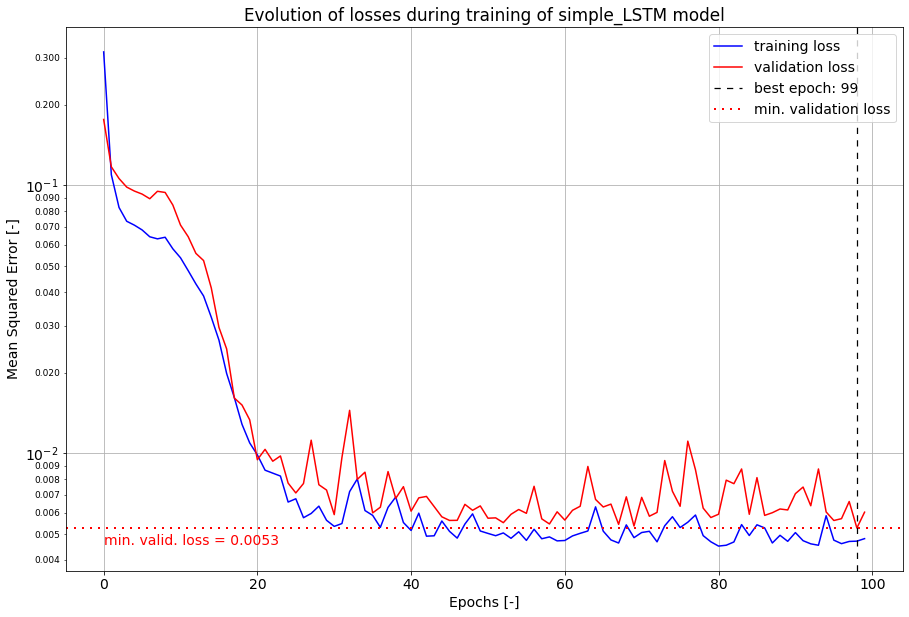

MSE on test set for fold 1 = 0.006027
MAE on test set for fold 1 = 0.055771
Starting k-fold cross validation for fold 2
Training the simple_LSTM model for 100 epochs
Time taken for training: 60.169 s
Saved weights and model from epoch 70


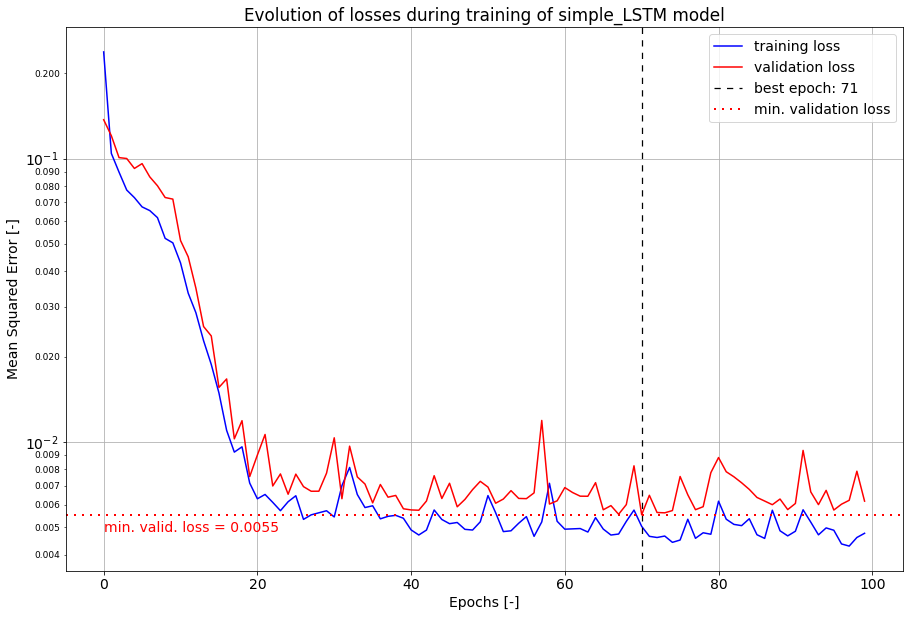

MSE on test set for fold 2 = 0.005357
MAE on test set for fold 2 = 0.053851
Starting k-fold cross validation for fold 3
Training the simple_LSTM model for 100 epochs
Time taken for training: 59.506 s
Saved weights and model from epoch 55


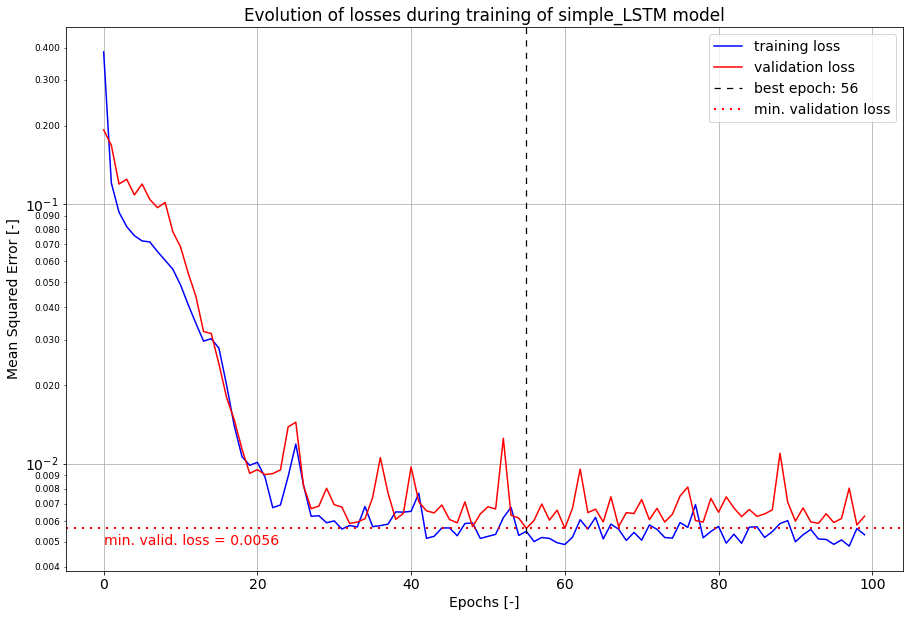

MSE on test set for fold 3 = 0.005408
MAE on test set for fold 3 = 0.056177
Starting k-fold cross validation for fold 4
Training the simple_LSTM model for 100 epochs
Time taken for training: 60.522 s
Saved weights and model from epoch 86


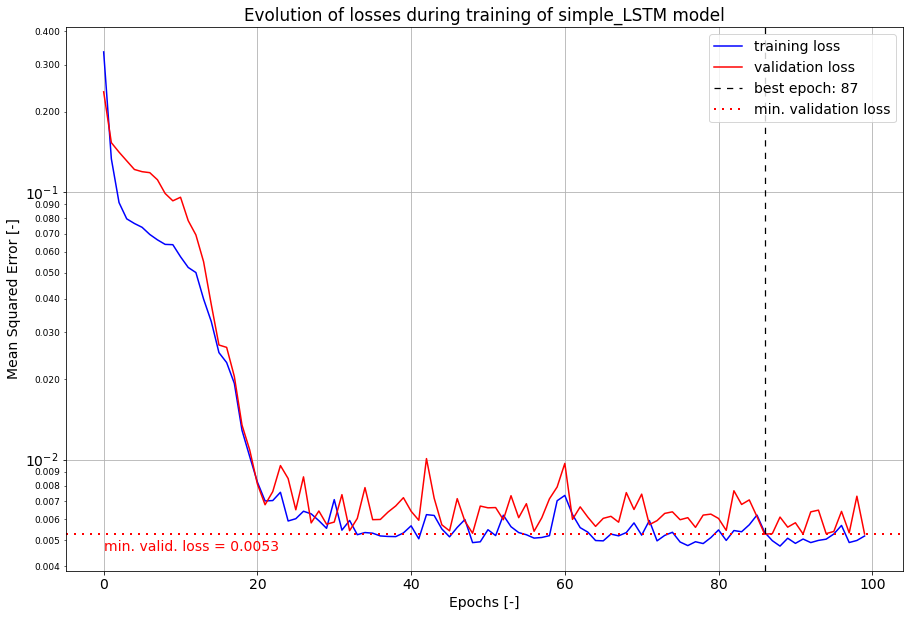

MSE on test set for fold 4 = 0.005614
MAE on test set for fold 4 = 0.053654
Starting k-fold cross validation for fold 5
Training the simple_LSTM model for 100 epochs
Time taken for training: 58.451 s
Saved weights and model from epoch 95


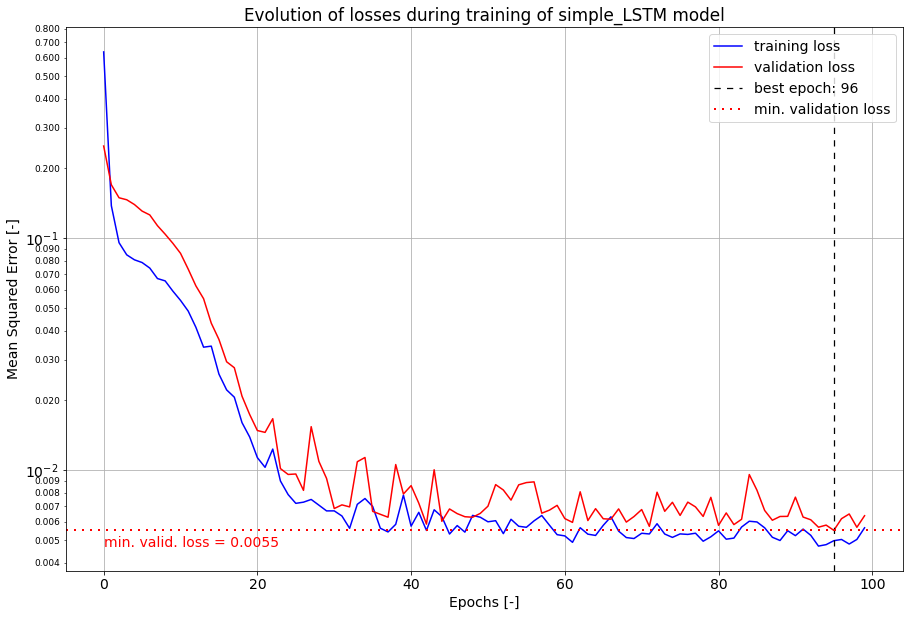

MSE on test set for fold 5 = 0.004917
MAE on test set for fold 5 = 0.051477
Final results after k-fold cross validation:
MSE = 0.005465 +/- 0.000362
MAE = 0.054186 +/- 0.001686


In [6]:
# Call helper function to perform k-fold cross validation
comparison_metrics = kfold_cv( k, x, y, true_mean, true_std, model_func, model_args, compile_kwargs, train_kwargs )

# 3. ACRNN Model

The Autoregressive Convolutional Recurrent Neural Network is implemented as proposed by the paper. The general structure of the model is described in Section 2, although the architecture used for reporting the results is not mentioned.

## 3.1. Configure the ACRNN Model

The hyperparameters (here) include:
  * the number of filters in the three 1D convolutional layers
  * the kernel size of the filters in the convolutional layers
  * the number of units in the three GRU layers
  
The MSE is used as the loss function. The MAE is also used as a comparison metric.

In [7]:
# Model configuration
n_timesteps  = x.shape[1]
n_features   = x.shape[2]
n_output     = y.shape[1]
conv_filters = [64,64,64]
conv_kernels = [7,5,3]
gru_units    = [20,20,20]

# Setup for k-fold cross validation
k              = 5
model_func     = ACRNN
model_args     = [ n_timesteps, n_features, n_output, conv_filters, conv_kernels, gru_units ] 
compile_kwargs = {'loss':'mse', 'metrics':['mae'], 'optimizer':'adam'}
train_kwargs   = {'epochs':100, 'batch_size':128, 'stopping_patience':50, 'dataset':dataset}

## 3.2. Train and evaluate the ACRNN model using k-fold cross validation

Model: "ACRNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
downsample_1 (AveragePooling1D) (None, 10, 1)        0           input[0][0]                      
__________________________________________________________________________________________________
downsample_2 (AveragePooling1D) (None, 5, 1)         0           input[0][0]                      
__________________________________________________________________________________________________
convolution_11 (Conv1D)         (None, 20, 64)       512         input[0][0]                      
______________________________________________________________________________________________

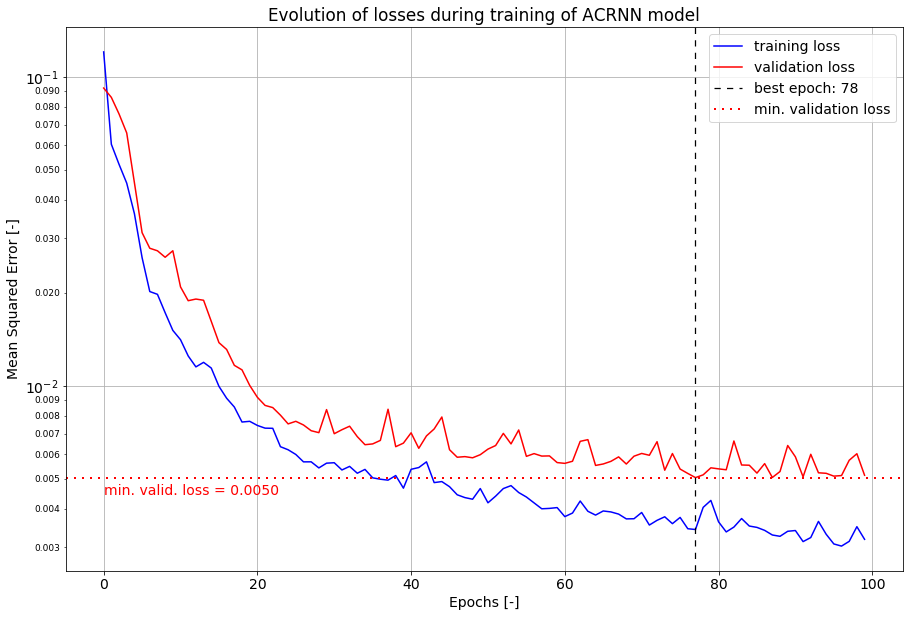

MSE on test set for fold 1 = 0.005331
MAE on test set for fold 1 = 0.054008
Starting k-fold cross validation for fold 2
Training the ACRNN model for 100 epochs
Time taken for training: 32.768 s
Saved weights and model from epoch 83


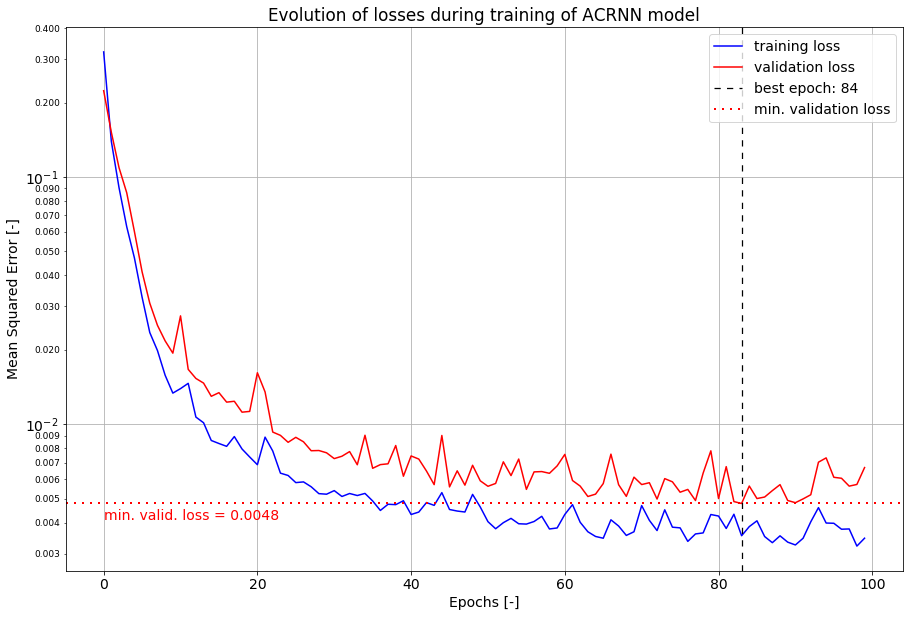

MSE on test set for fold 2 = 0.004591
MAE on test set for fold 2 = 0.050196
Starting k-fold cross validation for fold 3
Training the ACRNN model for 100 epochs
Time taken for training: 33.193 s
Saved weights and model from epoch 90


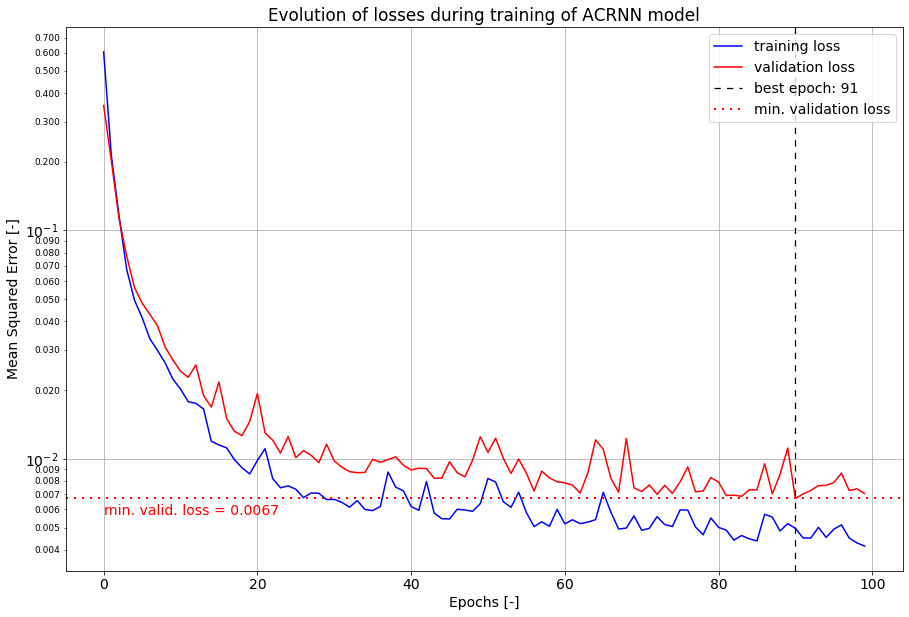

MSE on test set for fold 3 = 0.005763
MAE on test set for fold 3 = 0.053051
Starting k-fold cross validation for fold 4
Training the ACRNN model for 100 epochs
Time taken for training: 32.490 s
Saved weights and model from epoch 97


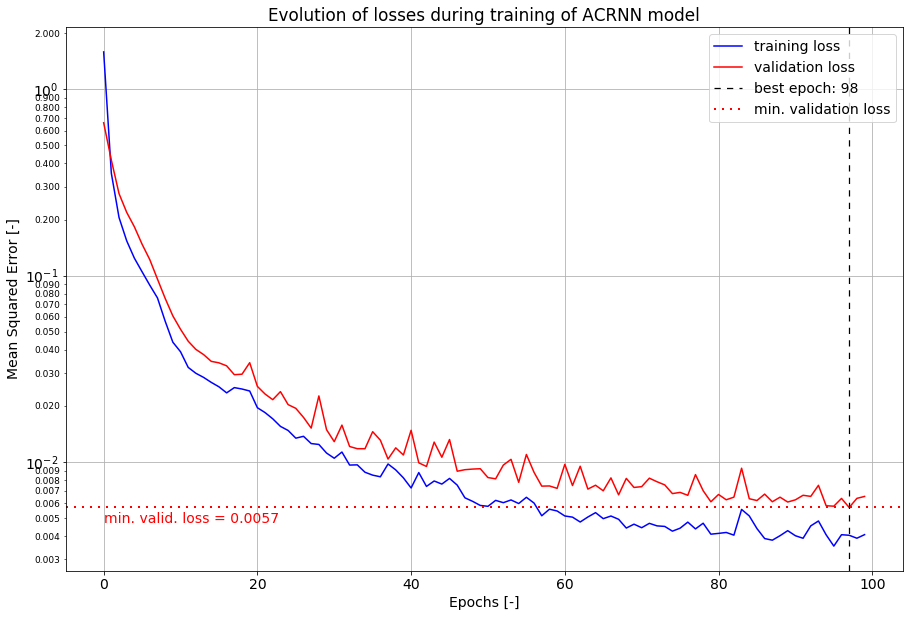

MSE on test set for fold 4 = 0.004965
MAE on test set for fold 4 = 0.049980
Starting k-fold cross validation for fold 5
Training the ACRNN model for 100 epochs
Time taken for training: 38.823 s
Saved weights and model from epoch 52


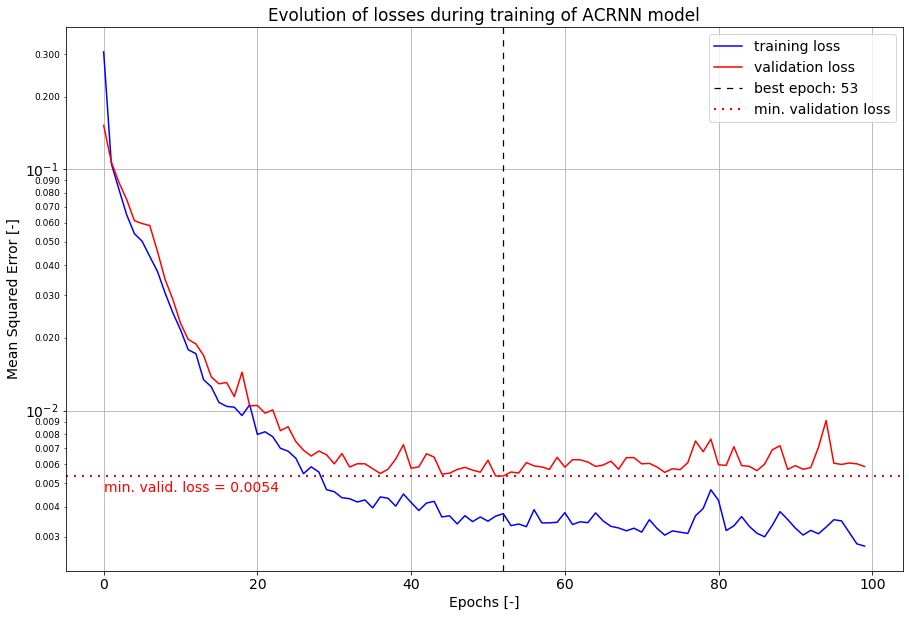

MSE on test set for fold 5 = 0.004300
MAE on test set for fold 5 = 0.047221
Final results after k-fold cross validation:
MSE = 0.004990 +/- 0.000520
MAE = 0.050891 +/- 0.002415


In [8]:
# Call helper function to perform k-fold cross validation
comparison_metrics = kfold_cv( k, x, y, true_mean, true_std, model_func, model_args, compile_kwargs, train_kwargs )